# A Short Tutorial for Accessing Data Using BigQuery

Here is a short tutorial on how to access our data on [Google Bigquery](https://cloud.google.com/bigquery). BigQuery is an analytical cloud platform for large datasets. To access our data, you will first need to have a Bigquery account. If you already have a Bigquery account, please skip to step 2. For example, if you see the screen below after clicking the link, you will need to create a Bigquery account first.
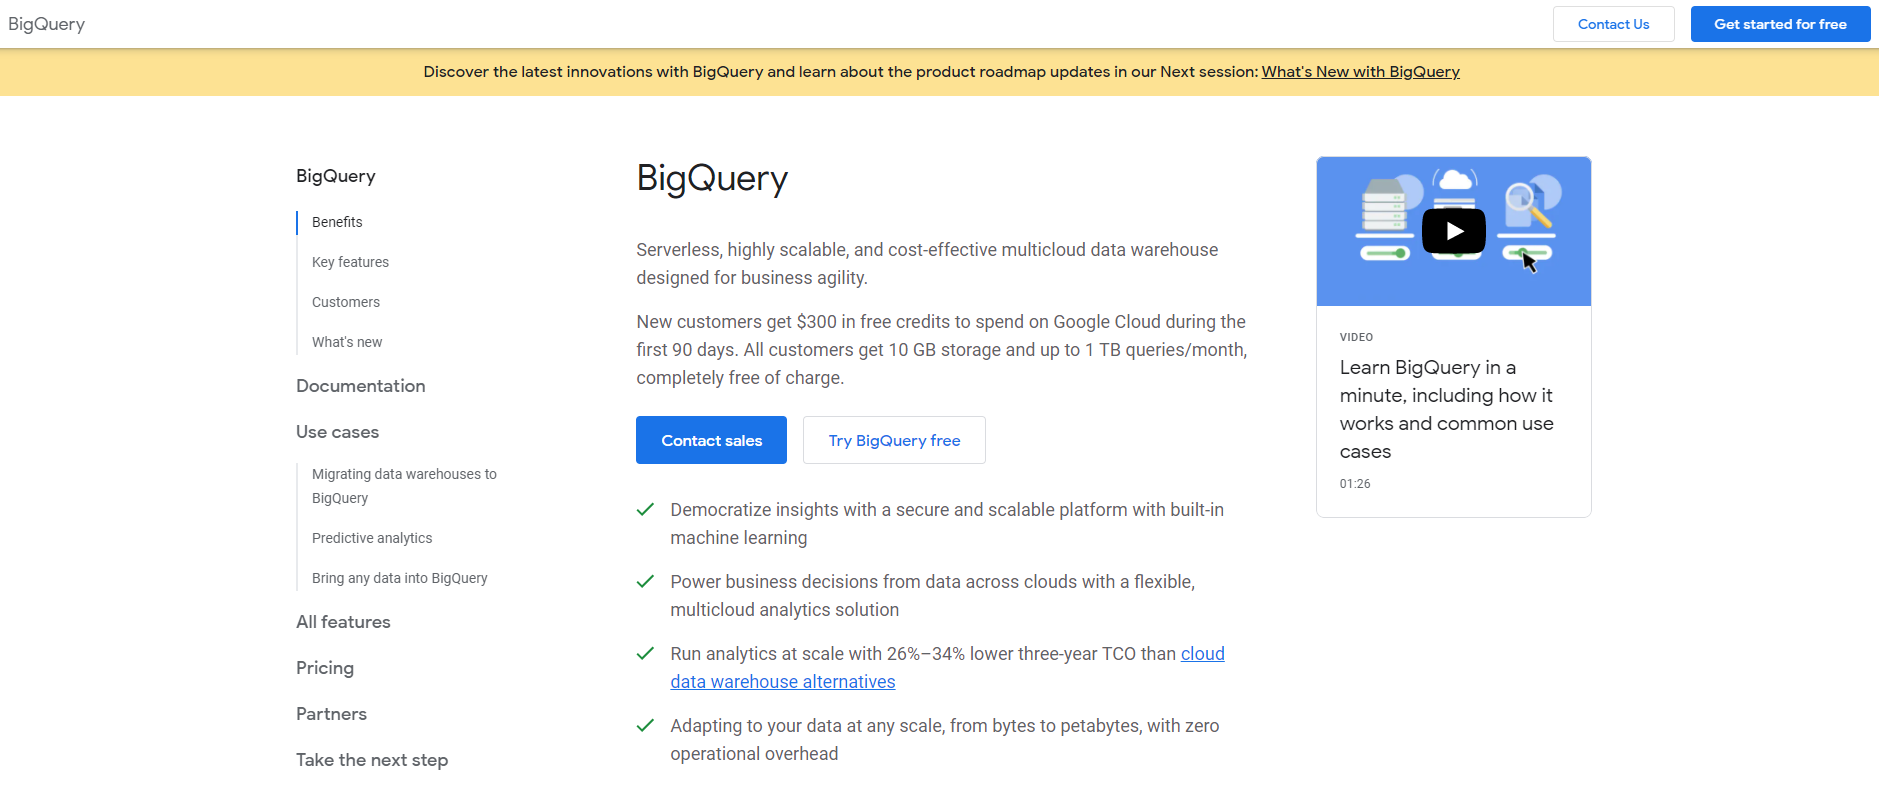




## 1. Create a Bigquery Account

To use Bigquery, you need to follow the next three steps. You will first need to create a Google account, and then to enable Billing and Bigquery on Google Cloud Platform. To do so, you will need a US credit card for registration.  

For your information, Bigquery is provided Google and it is not free. [Here](https://cloud.google.com/bigquery/pricing) is a detailed explanation of its pricing. However, Google Cloud Platform provides some credits for new users. Also, the first 1 TB analysis using Bigquery is free. We did some experiments with new users, all of them are able to analyze our data for free. 

To create a Bigquery account, you can follow the following three steps. If you have already had a Google account that is based in the United States, please skip the first step. 

1.   [Create a Google account](https://support.google.com/accounts/answer/27441?hl=en) 
2.   [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
3.   [Enable BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery) APIs for the project.

## 2. Access POI Dataset through Google Bigquery

Once you have created a Bigquery account, you will be able to enter the Bigquery Console.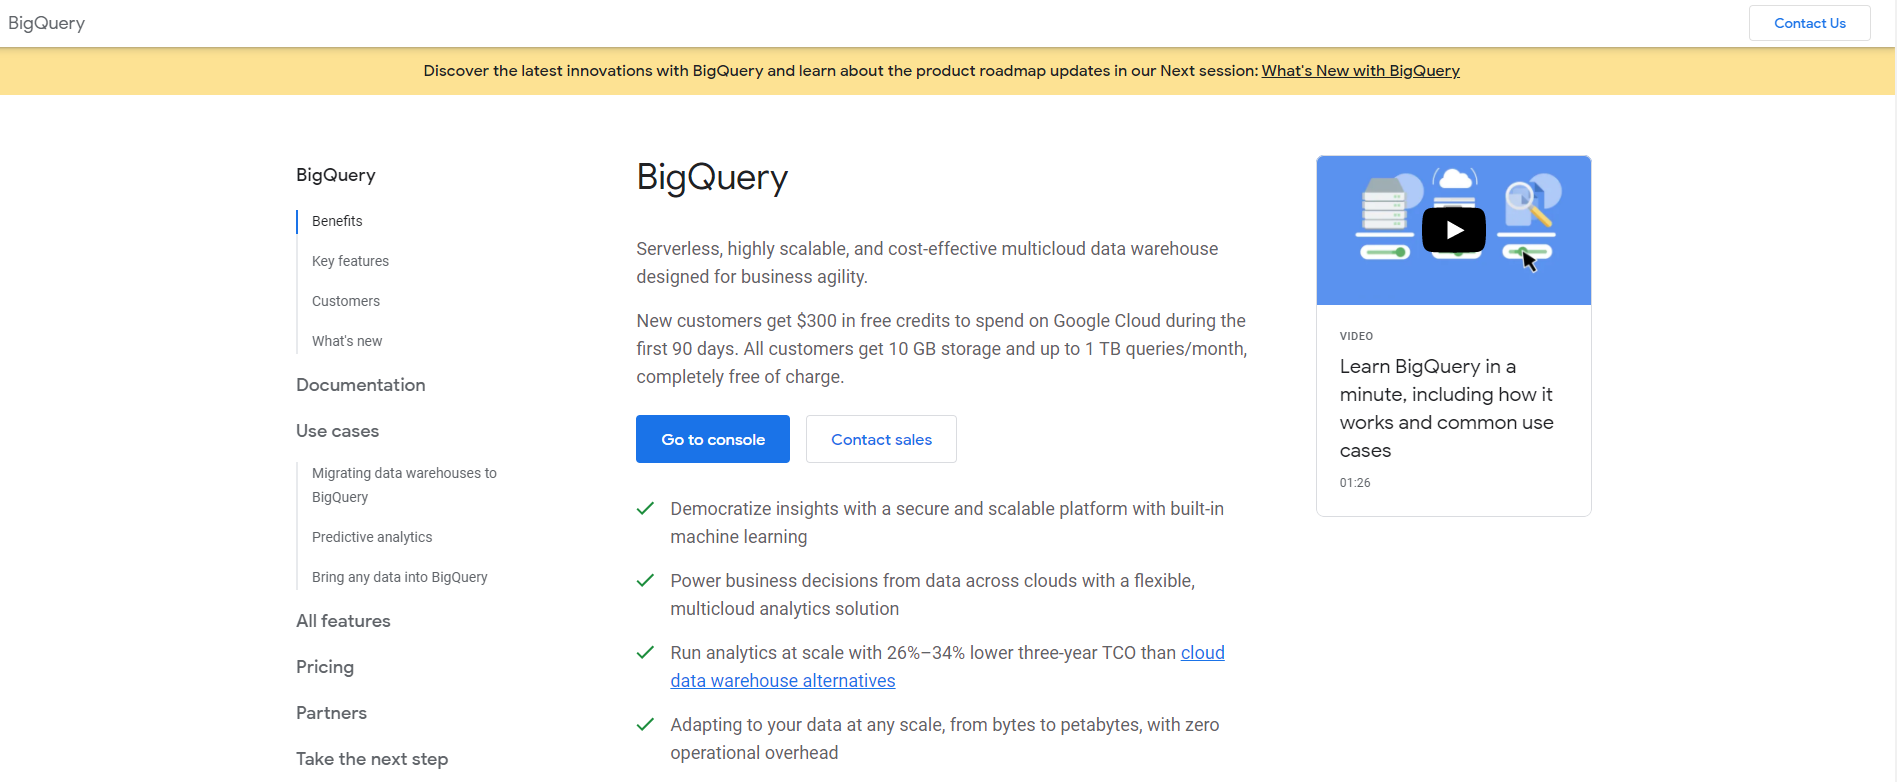 

In the Bigquery interface, you will first find the dataset that we are sharing through our project. To do so, click "+ ADD DATA," then select "Pin a project," and then select "Enter project name."
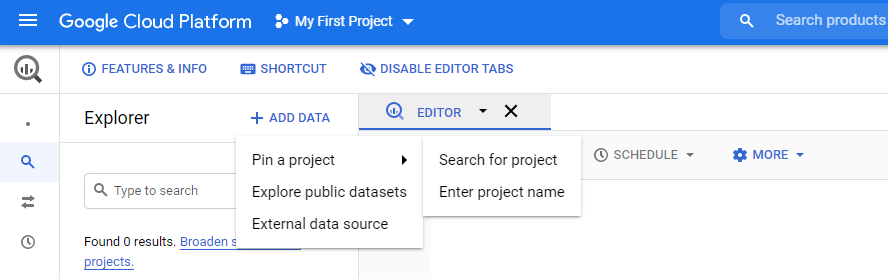

Enter the name of our project, "vigilant-balm-122322"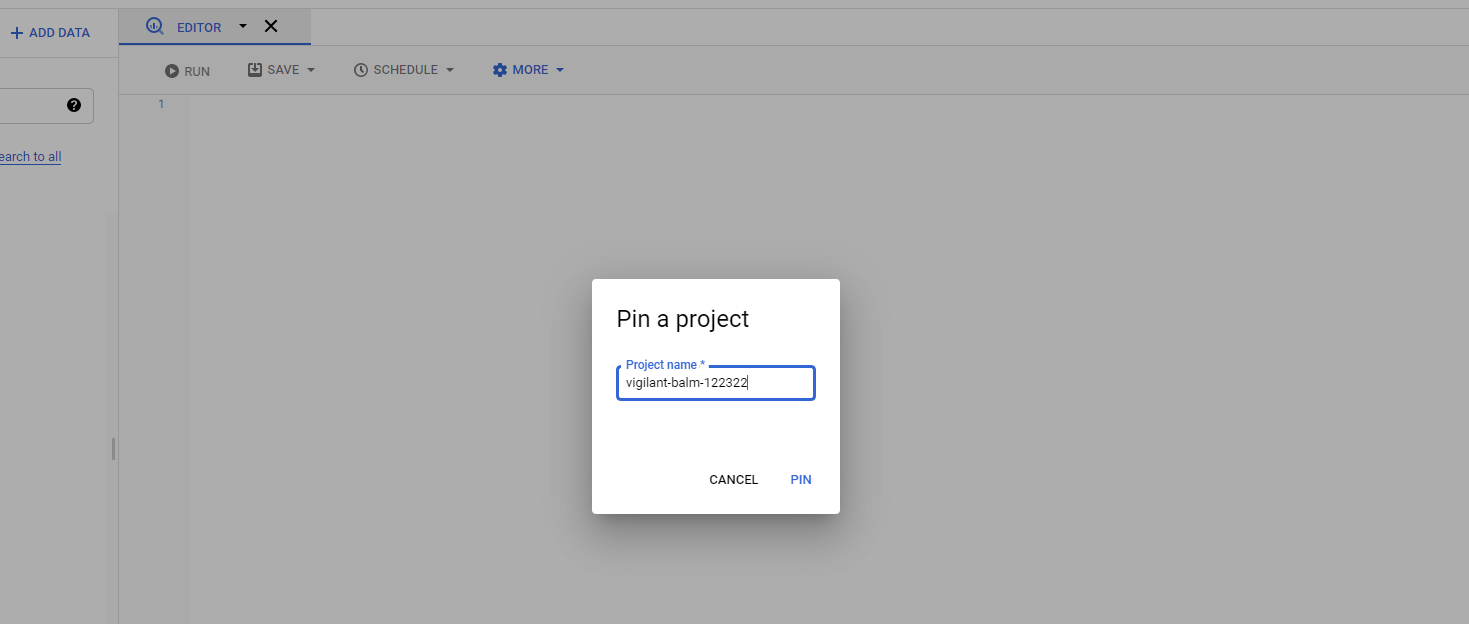

Then click "PIN." After that, our project will pop up on your left panel. By expanding the node, you will be able to see the "POIChina" dataset. Within the dataset, we have shared several data tables, each of which responds to a POI dataset from a specific source and year. For example, "gaode2018" refers to the government POIs that are available on Amap circa 2018. You should be able to query each table by click the "QUERY" button on the top right corner. 
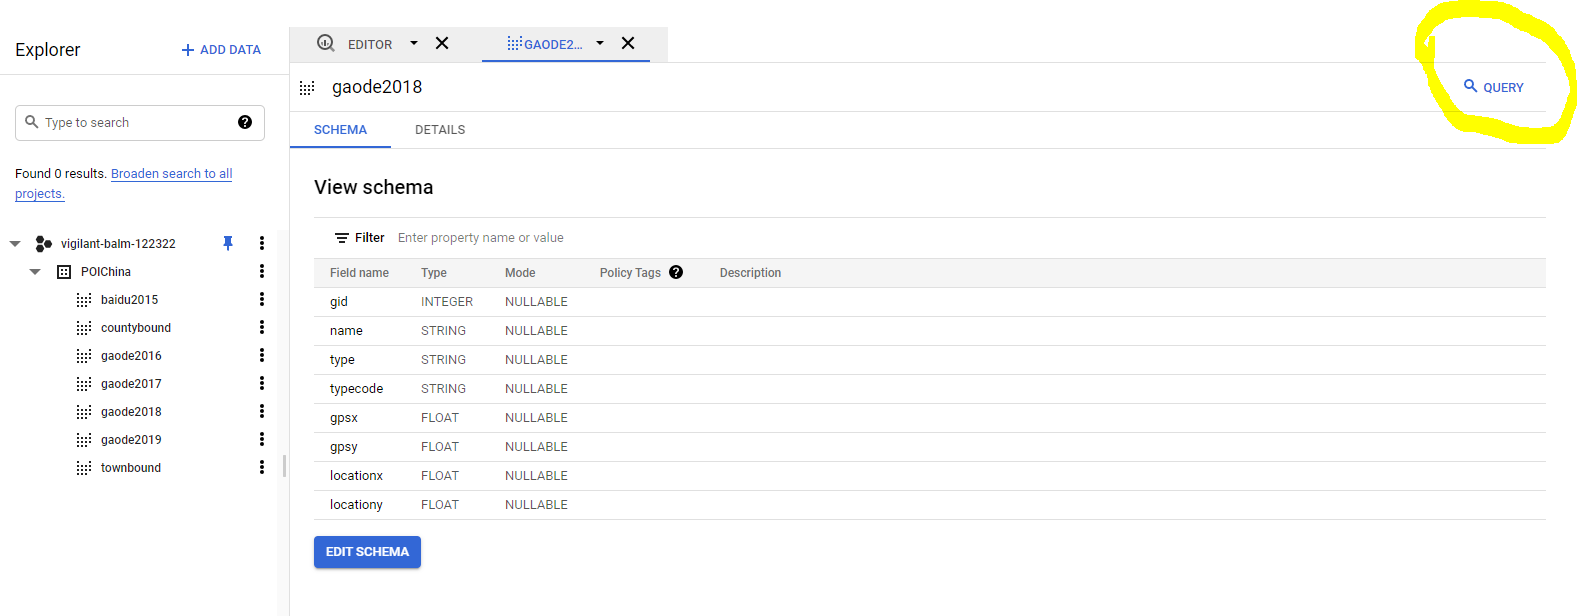 

Alternatively, you can click the "COMPOSE NEW QUERY" directly. For example, if you want to browse the top 1,000 records in the Gaode (Amap) POI circa 2018, you can write an SQL query 


```
SELECT * 
FROM `vigilant-balm-122322.POIChina.gaode2018`
LIMIT 1000
```

Then click the "RUN" button. It will return the records in the "Query Results."
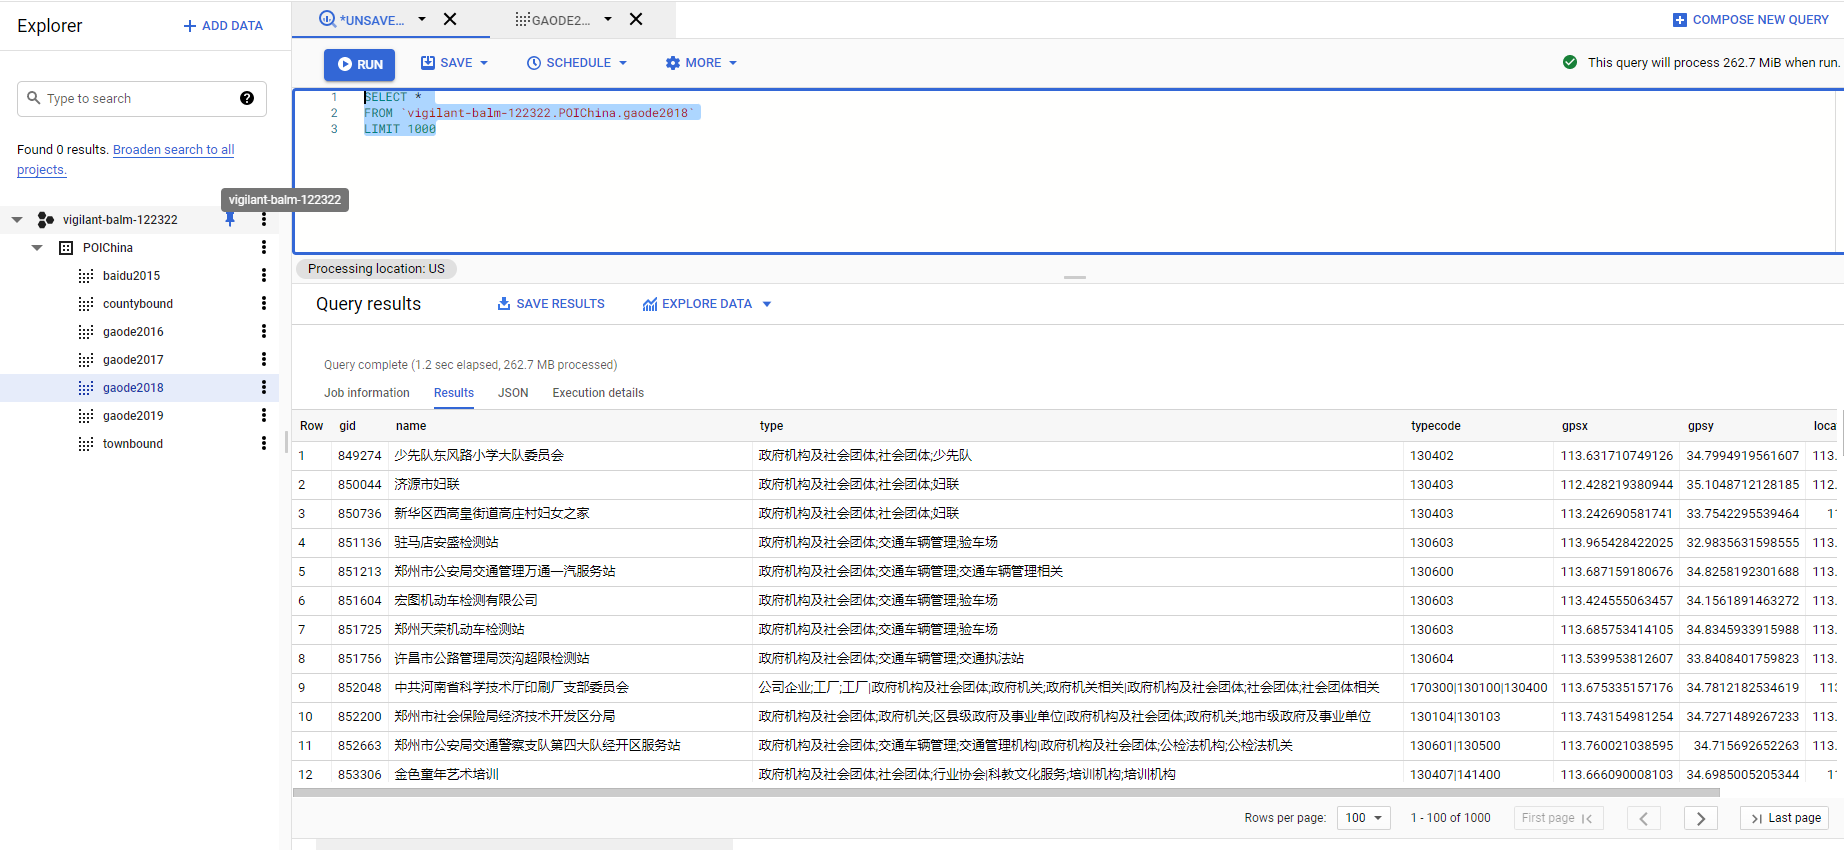


You can save the results to your local machine or export it to your Google Drive. 

## 3. Analyze POIs at the County or Township Level 

One advantage of POI data is that the measure itself is highly precise geographically. It enables us to analyze the data at any aggregated level. 

To make your analysis easy, we have also uploaded two data tables with county and township administrative boundaries. If you are familiar with GIS, you can also upload your own GIS data to your Bigquery project and use it for analysis. 


Gaode (Amap) has shared its categorization of POIs on its [webiste](https://lbs.amap.com/api/webservice/download). Each POI has three levels of categories, from broad to specific. 

Suppose we are interested in the variations of the following government agencies at the township level


| Typecode     | Description |
| ----------- | ----------- |
| 130105      | Township level government agencies and institutions       |
| 130106   | Sub-township level government agencies and institutions        |
| 130501      | Police stations       |
| 130502   | Procuratorate        |
| 130503      | Court      |
| 130505  | Notary        |
| 130506     | Social security       |
| 130701  | Administration for Industry & Commerce        |
| 130702      | State Tax Authority       |
| 130703   | Local Tax Authority        |




We can use SQL query to count the number of government agencies that matches these POI types within each township.


```
SELECT td.gid, count(gd.gid) numpts
FROM 
  `vigilant-balm-122322.POIChina.gaode2018` gd,
  `vigilant-balm-122322.POIChina.townbound` td
WHERE 
  (gd.typecode like '%130105%' or gd.typecode like '%130106%' or gd.typecode like '%130501%' or gd.typecode like '%130502%' or gd.typecode like '%130503%' or gd.typecode like '%130505%' or gd.typecode like '%130506%' or gd.typecode like '%130701%' or gd.typecode like '%130702%' or gd.typecode like '%130703%')
  AND ST_CONTAINS(td.geom, ST_GEOGPOINT(gd.locationx, gd.locationy))
GROUP BY
  td.gid
```



## 4. Analyze POIs Globally Using OpenStreetMap 

Lastly, Google Bigquery will provide many datasets that are publicly available. One useful dataset is the [OpenStreetMap](https://www.openstreetmap.org/#map=4/36.96/104.17). OpenStreetMap (OSM) is a collaborative platform that allows ordinary users to add, edit, and download geographical information, including POI data. 

[Planet OSM](https://planet.openstreetmap.org/) provides weekly OSM data file for download. This dataset includes POI data worldwide, which is accessible through Google Bigquery. The size of the data amounts to hundreds of gigatypes. However, Bigquery can help us quickly analyze the data in seconds.



For example, if we are interested in the variations of government agencies across countries, we can use SQL query to analyze the number of agencies by country.

```
--define bounding area of each country
WITH bounding_area AS (SELECT 
  osm_id, geometry,
  st_area(geometry) as area
FROM `bigquery-public-data.geo_openstreetmap.planet_features`
WHERE 
  feature_type="multipolygons"
  AND ('admin_level', '2') IN (SELECT (key, value) FROM unnest(all_tags))
  AND ('boundary', 'administrative') IN (SELECT (key, value) FROM unnest(all_tags))
ORDER BY area desc
)
SELECT bounding_area.osm_id, poi.poitype, count(poi.id) as num_gov --count number of POIs by type and country
FROM
(
SELECT nodes.id, osm_timestamp,  tags.value as poitype, geometry -- select government POIs
FROM `bigquery-public-data.geo_openstreetmap.planet_nodes` AS nodes
JOIN UNNEST(all_tags) AS tags
WHERE (tags.key = 'amenity'
  AND tags.value IN ("police", 
  "fire_station", 
  "post_office", 
  "townhall", 
  "courthouse", 
  "prison", 
  "embassy", 
  "community_centre", 
  "public_building")
)
) poi, bounding_area 
WHERE ST_DWithin(bounding_area.geometry, poi.geometry, 0)
GROUP by bounding_area.osm_id, poi.poitype
```



Because we aggregate the number of government agencies by country and POI type, the results would show up in thousands of rows. We can now "SAVE RESULTS" to our local machine.
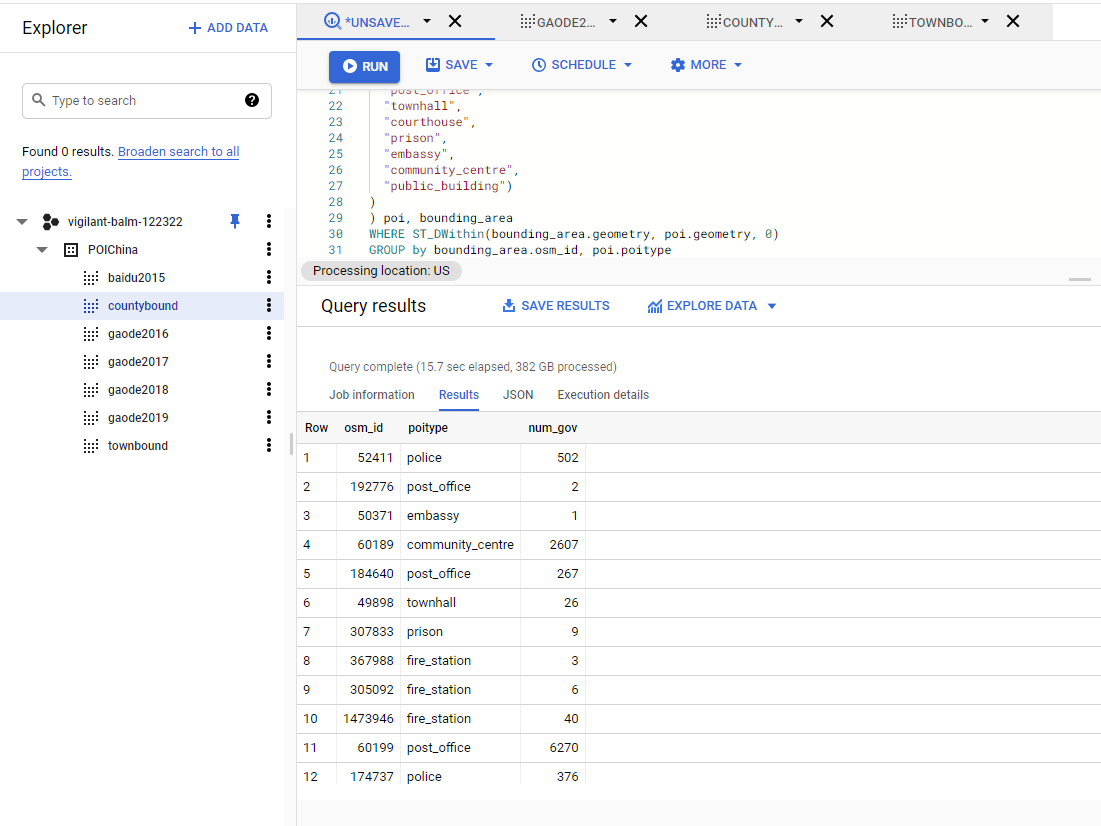